## 1. 定义算法

### 1.1. 定义模型

注意DDGP中critic网络的输入是state加上action。

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim = 256, init_w=3e-3):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
        
class Critic(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim=256, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### 1.2 定义经验回放

In [2]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

In [3]:
import torch.optim as optim
import numpy as np
class DDPG:
    def __init__(self, models,memories,cfg):
        self.device = torch.device(cfg['device'])
        self.critic = models['critic'].to(self.device)
        self.target_critic = models['critic'].to(self.device)
        self.actor = models['actor'].to(self.device)
        self.target_actor = models['actor'].to(self.device)
        
        # 复制参数到目标网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),  lr=cfg['critic_lr'])
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg['actor_lr'])
        self.memory = memories['memory']
        self.batch_size = cfg['batch_size']
        self.gamma = cfg['gamma']
        self.tau = cfg['tau']  # 软更新参数
    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.detach().cpu().numpy()[0, 0]
    @torch.no_grad()
    def predict_action(self, state):
        ''' 用于预测，不需要计算梯度
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.cpu().numpy()[0, 0]
    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中中随机采样一个批量的transition
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        # 转变为张量
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        # 注意看伪代码，这里的actor损失就是对应策略即actor输出的action下对应critic值的负均值
        actor_loss = self.critic(state, self.actor(state))
        actor_loss = - actor_loss.mean()

        next_action = self.target_actor(next_state)
        target_value = self.target_critic(next_state, next_action.detach())
        # 这里的expected_value就是伪代码中间的y_i  
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)

        actual_value = self.critic(state, action)
        critic_loss = nn.MSELoss()(actual_value, expected_value.detach())
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # 各自目标网络的参数软更新
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )

## 2. 定义训练

注意测试函数中不需要动作噪声

In [4]:
class OUNoise(object):
    '''Ornstein–Uhlenbeck噪声
    '''
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.n_actions   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.obs = np.ones(self.n_actions) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作加上噪声后进行剪切

def train(cfg, env, agent):
    print("开始训练！")
    ou_noise = OUNoise(env.action_space)  # 动作噪声
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg['train_eps']):
        state = env.reset()
        ou_noise.reset()
        ep_reward = 0
        for i_step in range(cfg['max_steps']):
            action = agent.sample_action(state)
            action = ou_noise.get_action(action, i_step+1) 
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push((state, action, reward, next_state, done))
            agent.update()
            state = next_state
            if done:
                break
        if (i_ep+1)%10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}")
        rewards.append(ep_reward)
    print("完成训练！")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("开始测试！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg['test_eps']):
        state = env.reset() 
        ep_reward = 0
        for i_step in range(cfg['max_steps']):
            action = agent.predict_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    return {'rewards':rewards}

## 3. 定义环境

In [5]:
import gym
import os
import torch
import numpy as np
import random
class NormalizedActions(gym.ActionWrapper):
    ''' 将action范围重定在[0.1]之间
    '''
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        return action
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = NormalizedActions(gym.make(cfg['env_name'])) # 装饰action噪声
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    models = {"actor":Actor(n_states,n_actions,hidden_dim=cfg['actor_hidden_dim']),"critic":Critic(n_states,n_actions,hidden_dim=cfg['critic_hidden_dim'])}
    memories = {"memory":ReplayBuffer(cfg['memory_capacity'])}
    agent = DDPG(models,memories,cfg)
    return env,agent

## 4. 设置参数

In [6]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DDPG',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='Pendulum-v1',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=300,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--max_steps',default=100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.99,type=float,help="discounted factor")
    parser.add_argument('--critic_lr',default=1e-3,type=float,help="learning rate of critic")
    parser.add_argument('--actor_lr',default=1e-4,type=float,help="learning rate of actor")
    parser.add_argument('--memory_capacity',default=8000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=128,type=int)
    parser.add_argument('--target_update',default=2,type=int)
    parser.add_argument('--tau',default=1e-2,type=float)
    parser.add_argument('--critic_hidden_dim',default=256,type=int)
    parser.add_argument('--actor_hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")  
    parser.add_argument('--seed',default=1,type=int,help="random seed")
    args = parser.parse_args([])    
    args = {**vars(args)} # 将args转换为字典  
    # 打印参数
    print("训练参数如下：")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("参数名","参数值","参数类型"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))                  
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg,path=None,tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. 我准备好了！

训练参数如下：
        参数名         	        参数值         	        参数类型        
     algo_name      	        DDPG        	   <class 'str'>    
      env_name      	    Pendulum-v1     	   <class 'str'>    
     train_eps      	        300         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
     max_steps      	       100000       	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
     critic_lr      	       0.001        	  <class 'float'>   
      actor_lr      	       0.0001       	  <class 'float'>   
  memory_capacity   	        8000        	   <class 'int'>    
     batch_size     	        128         	   <class 'int'>    
   target_update    	         2          	   <class 'int'>    
        tau         	        0.01        	  <class 'float'>   
 critic_hidden_dim  	        256         	   <class 'int'>    
  actor_hidden_dim  	        256         	   <class 'int'>    
       device       	        cpu         	   <c

E:\python\miniconda3\envs\rl\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
E:\python\miniconda3\envs\rl\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
E:\python\miniconda3\envs\

回合：10/300，奖励：-1173.09
回合：20/300，奖励：-1498.70
回合：30/300，奖励：-881.34
回合：40/300，奖励：-856.37
回合：50/300，奖励：-778.93
回合：60/300，奖励：-892.66
回合：70/300，奖励：-629.06
回合：80/300，奖励：-761.43
回合：90/300，奖励：-793.16
回合：100/300，奖励：-475.94
回合：110/300，奖励：-125.04
回合：120/300，奖励：-615.44
回合：130/300，奖励：-727.24
回合：140/300，奖励：-603.64
回合：150/300，奖励：-646.46
回合：160/300，奖励：-473.54
回合：170/300，奖励：-1508.40
回合：180/300，奖励：-1485.38
回合：190/300，奖励：-968.34
回合：200/300，奖励：-1326.80
回合：210/300，奖励：-1510.98
回合：220/300，奖励：-1188.52
回合：230/300，奖励：-1224.71
回合：240/300，奖励：-615.34
回合：250/300，奖励：-822.63
回合：260/300，奖励：-1223.33
回合：270/300，奖励：-988.73
回合：280/300，奖励：-834.12
回合：290/300，奖励：-372.11
回合：300/300，奖励：-512.49
完成训练！
开始测试！
回合：1/20，奖励：-239.79
回合：2/20，奖励：-113.90
回合：3/20，奖励：-239.31
回合：4/20，奖励：-245.47
回合：5/20，奖励：-126.34
回合：6/20，奖励：-126.97
回合：7/20，奖励：-358.60
回合：8/20，奖励：-355.34
回合：9/20，奖励：-0.16
回合：10/20，奖励：-237.76
回合：11/20，奖励：-367.64
回合：12/20，奖励：-479.70
回合：13/20，奖励：-121.31
回合：14/20，奖励：-237.72
回合：15/20，奖励：-125.49
回合：16/20，奖励：-241.74
回合：17/20，奖励：-0.40
回

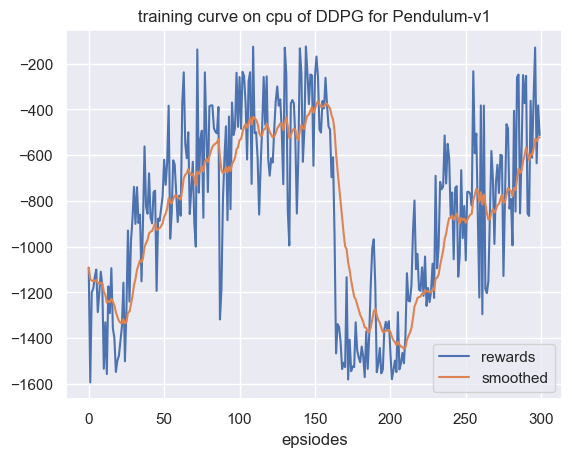

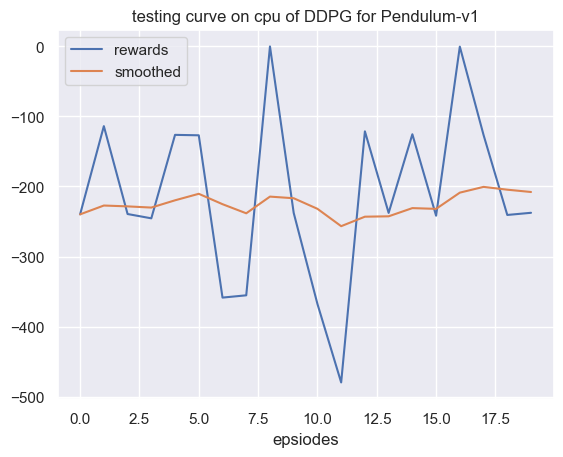

In [7]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果